# Quiver Orientation Picture

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import threading
import time
import requests

import numpy as np 
from collections import deque

import os
import utm 
import math 
import string
import base64
from io import BytesIO
from PIL import Image

from openai import OpenAI

from google import genai

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

def convert_angle_compass_to_cartesian(compass):
    return(((360 - compass) % 360) + 90) % 360


def encode_image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        img_b64_bytes = base64.b64encode(image_file.read())
        img_b64_str = img_b64_bytes.decode("utf-8")
    return img_b64_str


def resize_image(img_b64_str): 
    img_data = base64.b64decode(img_b64_str)
    img = Image.open(BytesIO(img_data))
    
    new_size = (img.width // 2, img.height // 2)
    resized_img = img.resize(new_size).convert('RGB')

    buffer = BytesIO()
    resized_img.save(buffer, format="JPEG")  
    buffer.seek(0)
    
    resized_img_b64 = base64.b64encode(buffer.read()).decode('utf-8')
    return resized_img_b64


def resize_images(byte_imgs):
    resized_images = []
    
    for img_b64_str in byte_imgs:
        resized_images.append(resize_image(img_b64_str))
        
    return resized_images


key = os.environ.get("OPENAI_API_KEY")
openai_api_client = OpenAI(api_key = key)

key = os.environ.get("GEMINI_API_KEY")
gemini_api_client = genai.Client(api_key=key)

In [180]:
def points_between(start, end, num):
    x_points = np.linspace(start[0], end[0], num) 
    y_points = np.linspace(start[1], end[1], num) 

    points = [(x, y) for x, y in zip(x_points, y_points)]
    return points 


def dist_between_latlon(start, end):
     start_pos = utm.from_latlon(start[0], start[1])
     end_pos = utm.from_latlon(end[0], end[1])

     return np.linalg.norm(np.array(start_pos[:2]) - np.array(end_pos[:2]))


class Map():

    def __init__(self, bounds, border=0.001):
        """ Bounds entered as [[min_lat, min_long], [max_lat, max_long]]"""

        self.marker_size = 9
        self.bounds = bounds 
        self.min_lat, self.min_long = self.bounds[0]
        self.max_lat, self.max_long = self.bounds[1]

        tiler = cimgt.OSM()
        crs = tiler.crs

        self.fig, self.ax = plt.subplots(
            figsize=(12, 10),
            subplot_kw={"projection": crs}
        )

        self.ax.set_extent([bounds[0][1], bounds[1][1] , 
                    bounds[0][0], bounds[1][0]], 
                    crs=ccrs.PlateCarree())
        self.ax.add_image(tiler, 18)  # Add OpenStreetMap tiles; zoom level lower values = less zoomed-in
        
        self.rows = self.cols = None 

    def save_map(self, path):
        plt.savefig(path, dpi=300, bbox_inches="tight")

    def visualize(self):
        plt.show()

    def add_grid(self, rows, cols):
        if self.rows is not None or self.cols is not None:
            raise ValueError("Grid already added to map, cannot add another one.")
        
        self.gridlines = []
        self.gridlabels = []
        self.rows, self.cols = rows, cols

        # Generate lat/lon grid points
        latitudes = np.linspace(self.min_lat, self.max_lat, self.rows + 1)
        longitudes = np.linspace(self.min_long, self.max_long, self.cols + 1)

        # Plot horizontal grid lines and add row labels
        for i, lat in enumerate(latitudes):
            line = self.ax.plot([self.min_long, self.max_long], [lat, lat], 
                    color="black", linewidth=0.5, linestyle="--", 
                    transform=ccrs.PlateCarree())

            row_label = f"{i}" 
            label = self.ax.text(self.min_long - 0.0003, lat, row_label, 
                    fontsize=10, ha="right", va="center", color="black",
                    transform=ccrs.PlateCarree())
            
            self.gridlines.append(line)
            self.gridlabels.append(label)

        # Plot vertical grid lines and add column labels
        for j, lon in enumerate(longitudes):
            line = self.ax.plot([lon, lon], [self.min_lat, self.max_lat], 
                    color="black", linewidth=0.5, linestyle="--", 
                    transform=ccrs.PlateCarree())

            col_label = f"{j}" 
            label = self.ax.text(lon, self.min_lat - 0.0003, col_label, 
                    fontsize=10, ha="center", va="top", color="black",
                    transform=ccrs.PlateCarree())
            
            self.gridlines.append(line)
            self.gridlabels.append(label)

    def remove_grid(self):
        if self.rows is None and self.cols is None:
            raise ValueError("Grid has not been added to map, cannot remove.")
        
        for line in self.gridlines:
            line[0].remove()

        for label in self.gridlabels:
            label.remove()

        self.rows = self.cols =  None
        self.gridlines = self.gridlabels = None

    def plot_points(self, points, colors, lat_lon = True):
        if isinstance(colors, list) and not isinstance(colors, str):
            if len(points) != len(colors):
                raise ValueError(f"Must have lengths of lists for plotting equal, have {len(points)} points but {len(colors)} colors")
        else:
            color = colors 

        for i in range(len(points)):
            lat, lon = points[i]

            if not lat_lon:
                lat, lon = self.coords_to_lat_long(lat, lon)

            if isinstance(colors, list) and not isinstance(colors, str):
                color = colors[i]

            self.ax.plot(lon, lat, marker="o", color=color, markersize=self.marker_size, transform=ccrs.PlateCarree())
            
    def remove_points(self, num, color):
        count = 0
        for line in reversed(self.ax.lines):  
            if line.get_marker() == "o" and line.get_color() == color:
                line.remove()
                count += 1
                if count >= num:  # Stop after removing 'num' points
                    break  

    def coords_to_lat_long(self, x, y):
        if self.rows is None or self.cols is None:
            raise ValueError("Cannot compute coordinates from lat long without a grid")
        
        long  = self.min_long + x * (self.max_long - self.min_long) / self.cols
        lat = self.min_lat + y * (self.max_lat - self.min_lat) / self.rows

        return lat, long 
    
    def lat_long_to_coords(self, lat, long):
        if self.rows is None or self.cols is None:
            raise ValueError("Cannot compute lat long from coordinates without a grid")
        
        x = (long - self.min_long) / ((self.max_long - self.min_long) / self.cols)
        y = (lat - self.min_lat) / ((self.max_lat - self.min_lat) / self.rows)

        return x, y 


want 7.79920172074914 waypoints


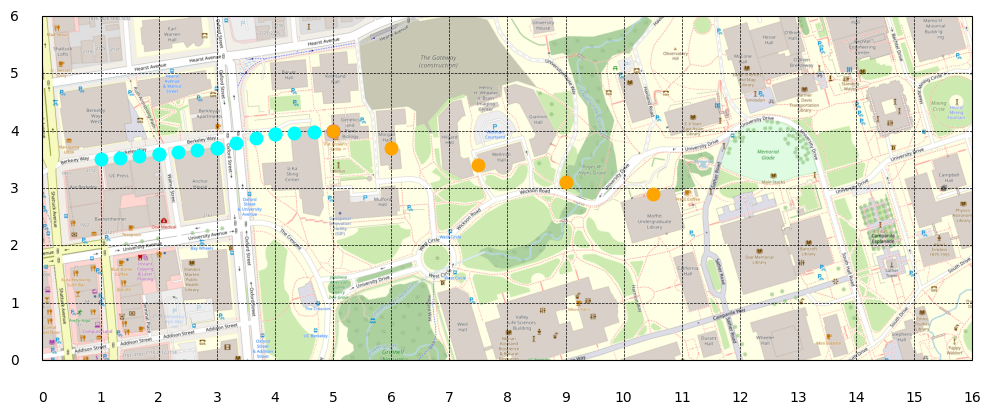

In [183]:
cur_pos = np.array([37.873550 , -122.267617])
campanile_pos = np.array([37.87210, -122.25780])

points = np.vstack([cur_pos, campanile_pos])
min_lat, min_long = np.min(points, axis = 0)
max_lat, max_long = np.max(points, axis = 0)

border = 0.001
bounds = [[min_lat - border, min_long - border],
        [max_lat + border, max_long + border]]


my_map = Map(bounds)
my_map.add_grid(6, 16)


# connect a couple spots as "visited"

# my_map.plot_points(points_between((0, 3.5), (3.2, 4), 8), "cyan", False)
my_map.plot_points(points_between((1, 3.5), (2, 3.6), 4), "cyan", False)
my_map.plot_points(points_between((2, 3.6), (3.0, 3.7), 4), "cyan", False)
my_map.plot_points(points_between((3.0, 3.7), (4.000, 3.950), 4), "cyan", False)
my_map.plot_points(points_between((4.000, 3.950), (5.000, 4.000), 4), "cyan", False)


# my_map.plot_points([cur_pos], ["fuchsia"])
# my_map.plot_points([(4, 3.7)], ["red"], False)

start_pos = (5.000, 4.000)
goal_pos = (11, 3.8)
my_map.plot_points([start_pos], ["fuchsia"], False)
# my_map.plot_points([goal_pos], ["blueviolet"], False)

# my_map.plot_points([(4.900, 3.700)], ["blueviolet"], False)
my_map.plot_points([campanile_pos], ["blueviolet"])
# my_map.plot_points([(4.4, 3.0)], ["blueviolet"], False)

my_map.save_map("griddy.png")


start_pos = my_map.coords_to_lat_long(start_pos[0], start_pos[1])
goal_pos = my_map.coords_to_lat_long(goal_pos[0], goal_pos[1])
print(f"want {dist_between_latlon(start_pos, goal_pos) / 50 } waypoints")

predicted_path = [
    (5.000, 4.000),
    (6.000, 3.700),
    (7.500, 3.400),
    (9.000, 3.100),
    (10.500, 2.900),
    (12.000, 2.500),
    (13.500, 2.300),
    (14.300, 2.100)
]

my_map.plot_points(predicted_path, "orange", False)
my_map.remove_points(1, "blueviolet")
my_map.remove_points(3, "orange")


my_map.save_map("with_points_3.png")
# # my_map.visualize()

In [142]:
start_pos = my_map.coords_to_lat_long(1, 3.5)
goal_pos = my_map.coords_to_lat_long(11, 3.8)

dist_between_latlon(start_pos, goal_pos) / 50 

np.float64(12.997369876461569)

In [ ]:
dist_between_latlon(my_map.coords_to_lat_long)

In [77]:
predicted_path = [
    (1.667, 4.500),   # Start
    (2.000, 4.500),   # East on Hearst
    (3.000, 4.500),   # Continue East on Hearst
    (4.000, 4.400),   # Continue East on Hearst
    (5.000, 4.300),   # Continue East on Hearst
    (6.000, 4.200),   # Continue East on Hearst
    (7.000, 4.100),   # Continue East on Hearst
    (8.000, 4.000),   # Continue East on Hearst
    (9.000, 3.900),   # Continue East on Hearst
    (10.000, 3.800),  # Continue East on Hearst
    (11.000, 3.700),  # Hearst changes to University
    (12.000, 3.600),  # Continue East on University
    (13.000, 3.500),  # Continue East on University
    (14.000, 3.400),  # Continue East on University
    (14.500, 3.200),  # South on Sather Road
    (14.700, 3.000),  # Continue South on Sather
    (14.800, 2.800),  # Continue South on Sather
    (14.833, 2.600),  # Continue South on Sather
    (14.833, 2.400),  # East towards Campanile Way
    (14.833, 2.300),  # South on Campanile Way
    (14.833, 2.167)    # Goal
]

In [78]:
my_map.plot_points(predicted_path, "orange", False)

In [79]:
my_map.save_map("with_points.png")

<Figure size 640x480 with 0 Axes>

In [ ]:
# In this overhead map, my position is marked with a bright fuchsia dot, locations I have visited are marked with light blue dots, red dots indicate spots I have gotten stuck at or couldn't make progress from, and a purple dot represents my goal position. The map is split into a coordinate grid, with labels along the x and y axis. What is my approximate current position? What is the approximate goal position? Use precision up to 3 decimal spots.

In [ ]:
# In this overhead map, my position is marked with a bright fuchsia dot, locations I have visited are marked with light blue dots, red dots indicate spots I have gotten stuck at or couldn't make progress from, and a purple dot represents my goal position. The map is split into a coordinate grid, with labels along the x and y axis. What is my approximate current position? What is the approximate goal position? Use precision up to 3 decimal spots. Give me a path from my current position to the goal position using 10 intermediate waypoints. Use precision up to 3 decimal spots. Format it like this [(x, y), (x, y), ..., (x, y)]. Keep in mind that I am a wheeled robot and cannot go through buildings, which are marked with brown on the map. White roads, gray roads, or red bike paths are easier for me to traverse. 

In [56]:
my_map.lat_long_to_coords(cur_pos[0], cur_pos[1])

(np.float64(0.42311923500216636), np.float64(2.1304347826091434))

In [29]:
my_map.visualize()

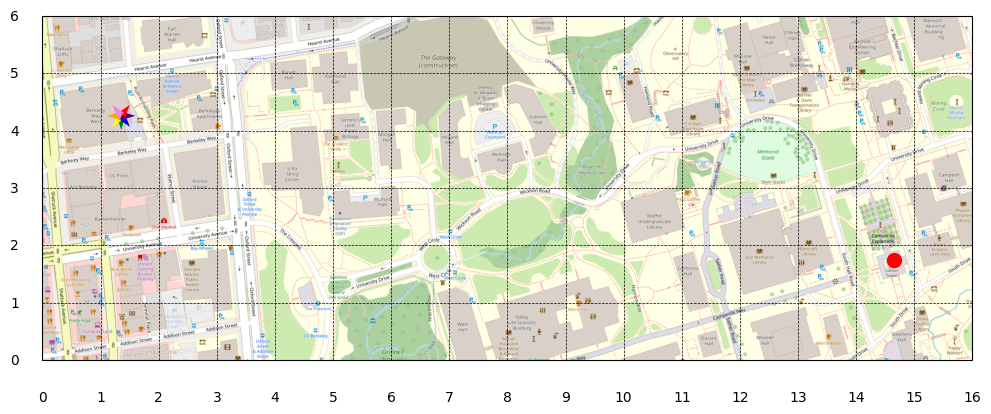

In [12]:

cur_pos = [37.873550 , -122.267617]
campanile_pos = np.array([37.87210, -122.25780])
goal_pose = campanile_pos
orientation = 180 
marker_size = 10

points = np.vstack([cur_pos, campanile_pos])
min_lat, min_long = np.min(points, axis = 0)
max_lat, max_long = np.max(points, axis = 0)

border = 0.001
map_bounds = [[min_lat - border, min_long - border],
        [max_lat + border, max_long + border]]

tiler = cimgt.OSM()
tiler._executor = None # so it doesn't do multithraeding so that it plays nice later 
crs = tiler.crs

fig, ax = plt.subplots(
    figsize=(12, 10),
    subplot_kw={"projection": crs}
)
ax.set_extent([map_bounds[0][1], map_bounds[1][1] , 
            map_bounds[0][0], map_bounds[1][0]], 
            crs=ccrs.PlateCarree())

ax.add_image(tiler, 18)  # Add OpenStreetMap tiles; zoom level lower values = less zoomed-in

ax.plot( # Plot goal position 
        goal_pose[1], goal_pose[0],
        marker="o", color="red", markersize=marker_size, 
        transform=ccrs.PlateCarree()
)


rad_orientation = np.radians(convert_angle_compass_to_cartesian(orientation))
arrow_length = 50
dx = arrow_length * np.cos(rad_orientation)
dy = arrow_length * np.sin(rad_orientation)

# big arrow in my direction 
# ax.quiver(
#     np.array([cur_pos[1]]), np.array([cur_pos[0]]),  # Start position
#     np.array([dx]), np.array([dy]),  # Direction vector
#     angles='xy', scale_units='xy', scale=1, color="green",
#     transform=ccrs.PlateCarree()
# )

offset_length = 30  # Length of the offset lines
angles = {
    "forward": (np.radians(0), "green"),           
    "forward_right": (np.radians(-45), "yellow"),    
    "forward_left": (np.radians(45), "blue"),    
    "right": (np.radians(-90), "orange"),             
    "left": (np.radians(90), "indigo"),              
    "back": (np.radians(180), "pink"),          
    "back_right": (np.radians(135), "red"),     
    "back_left": (np.radians(225), "violet"),        
}


for direction in angles.keys():
    angle_offset, color = angles[direction]
    total_angle = rad_orientation + angle_offset
    dx_offset = offset_length * np.cos(total_angle)
    dy_offset = offset_length * np.sin(total_angle)
    ax.quiver(
        np.array([cur_pos[1]]), np.array([cur_pos[0]]),  # Start position
        np.array([dx_offset]), np.array([dy_offset]),  # Direction vector
        angles='xy', scale_units='xy', scale=1.5, color= color,
        transform=ccrs.PlateCarree()
    )




# Define the number of rows (latitudes) and columns (longitudes)
num_rows, num_cols = 6, 16  # Adjust as needed

# Generate lat/lon grid points
latitudes = np.linspace(map_bounds[0][0], map_bounds[1][0], num_rows + 1)
longitudes = np.linspace(map_bounds[0][1], map_bounds[1][1], num_cols + 1)

# Plot horizontal grid lines and add row labels
for i, lat in enumerate(latitudes):
    ax.plot([map_bounds[0][1], map_bounds[1][1]], [lat, lat], 
            color="black", linewidth=0.5, linestyle="--", 
            transform=ccrs.PlateCarree())

    # Label rows on the left, aligned with grid lines
    row_label = f"{i}"  # 0 at bottom, increasing upwards
    ax.text(map_bounds[0][1] - 0.0003, lat, row_label, 
            fontsize=10, ha="right", va="center", color="black",
            # bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'),
            transform=ccrs.PlateCarree())

# Plot vertical grid lines and add column labels
for j, lon in enumerate(longitudes):
    ax.plot([lon, lon], [map_bounds[0][0], map_bounds[1][0]], 
            color="black", linewidth=0.5, linestyle="--", 
            transform=ccrs.PlateCarree())

    # Label columns at the bottom, aligned with grid lines
    col_label = f"{j}"  # 0 at left, increasing to the right
    ax.text(lon, map_bounds[0][0] - 0.0003, col_label, 
            fontsize=10, ha="center", va="top", color="black",
            # bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'),
            transform=ccrs.PlateCarree())
# # Add row labels (1-8) on the left side
# for i, lat in enumerate(latitudes[:-1]):  
#     row_label = f"{num_rows - i}"  # "1" at bottom, "8" at top
#     ax.text(map_bounds[0][1] - 0.0003,  # Slightly left of the grid
#             lat + (latitudes[1] - latitudes[0]) / 2,
#             row_label, fontsize=10, ha="right", va="center",
#             color="black", # bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'),
#             transform=ccrs.PlateCarree())

# # Add column labels (a-h) at the bottom
# for j, lon in enumerate(longitudes[:-1]):  
#     col_label = f"{string.ascii_lowercase[j]}"  # "a" at left, "h" at right
#     ax.text(lon + (longitudes[1] - longitudes[0]) / 2,
#             map_bounds[0][0] - 0.0003,  # Slightly below the grid
#             col_label, fontsize=10, ha="center", va="top",
#             color="black", # bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'),
#             transform=ccrs.PlateCarree())



plt.savefig("./current_map.png", dpi=300, bbox_inches="tight")


In [80]:
points = {"path": [{"x": 917, "y": 655}, {"x": 843, "y": 655}, {"x": 763, "y": 643}, {"x": 723, "y": 598}, {"x": 642, "y": 527}, {"x": 539, "y": 505}, {"x": 417, "y": 488}, {"x": 341, "y": 437}, {"x": 250, "y": 381}, {"x": 169, "y": 282}]}

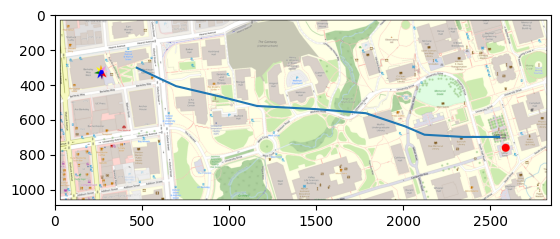

In [85]:
image = Image.open("./current_map.png")
xs = [p["x"] * image.width / 1024 for p in points["path"]]
ys = [p["y"] * image.height / 1024 for p in points["path"]]
plt.imshow(image)
plt.plot(xs, ys)

In [77]:
prompt = """ I am providing a birds eye view image of a map where my position and orientation are indicated by the green arrowhead 
            and my desired position is the red dot. """

for direction in angles.keys():
    angle_offset, color = angles[direction]
    prompt += f"On both the observation image and the birds eye view map, going in {direction} is marked with a {color} arrow"   


prompt += """What general direction should I go, in my frame of reference, to get closer to the red goal?
            Don't use cardinal directions. Instead, tell me broadly to go right / left / straight / forward / backwards or a combination of those. 
"""

In [78]:
# asking openAI

img_type_map = "image/png"
img_b64_str_map = encode_image_to_base64("./current_map.png")

content = [{"type": "text", "text": prompt}, 
            {"type": "image_url",
            "image_url": {"url": f"data:{img_type_map};base64,{img_b64_str_map}"}
            }]
    
response = openai_api_client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": content,
        }
    ],
    max_tokens = 1000,
)
print(response.choices[0].message.content)

To get closer to the red goal, you should go forward and slightly to the right.


In [79]:
# asking gemini
contents = [prompt] +  [resize_image(img_b64_str_map)]

response = gemini_api_client.models.generate_content(
    model="gemini-2.0-flash-exp",
    contents=contents)

print(response.text)

Go straight and a little to the right.



# Plot direction on image

In [63]:



def byte_to_pil(byte_img):
    img_data = base64.b64decode(byte_img)
    img = Image.open(BytesIO(img_data))
    return img 


def pil_to_byte(pil_img):
    pil_img = pil_img.convert('RGB') # no more transparency 
    buffer = BytesIO()
    pil_img.save(buffer, format="JPEG")  
    buffer.seek(0)
    
    base64_img = base64.b64encode(buffer.read()).decode('utf-8')
    return base64_img


def overlay_imgs(pil_img1, pil_img2):
    pil_img1 = pil_img1.convert("RGBA")
    pil_img2 = pil_img2.convert("RGBA")
    """ Put second pic on first """
    pil_img2 = pil_img2.resize(pil_img1.size)
    result = Image.alpha_composite(pil_img1, pil_img2)
    return result 



# combine images when one is transparent! 


In [ ]:
directions_overlay_path = "directions overlay.png"
directions_overlay_pil = Image.open(directions_overlay_path).convert("RGBA")


# screenshot = requests.get("http://127.0.0.1:8000/v2/screenshot")
# screenshot = screenshot.json() 
observation_byte = screenshot["front_frame"]
observation_pil = byte_to_pil(observation_byte)

observation_overlayed_pil = overlay_imgs(observation_pil, directions_overlay_pil)
observation_overlayed_byte = pil_to_byte(observation_overlayed_pil)

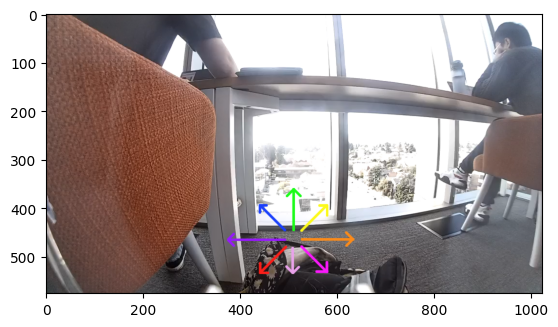

In [66]:
plt.imshow(obervation_overlayed_pil)

In [ ]:
img = byte_to_pil(pic)


In [50]:
# Get most recent data from robot
# screenshot = requests.get("http://127.0.0.1:8000/v2/screenshot")
# screenshot = screenshot.json() 
pic = screenshot["front_frame"]

img_data = base64.b64decode(pic)
img = Image.open(BytesIO(img_data))


In [54]:
img.width, img.height

(1024, 576)

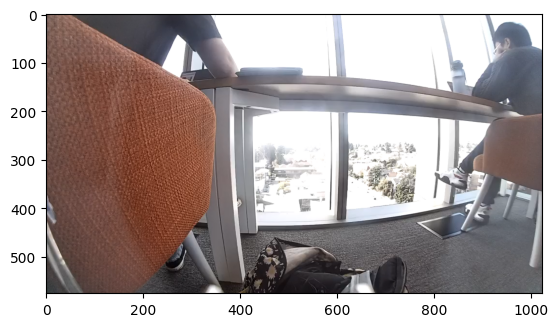

In [55]:
plt.imshow(img)

In [53]:
img.height

576

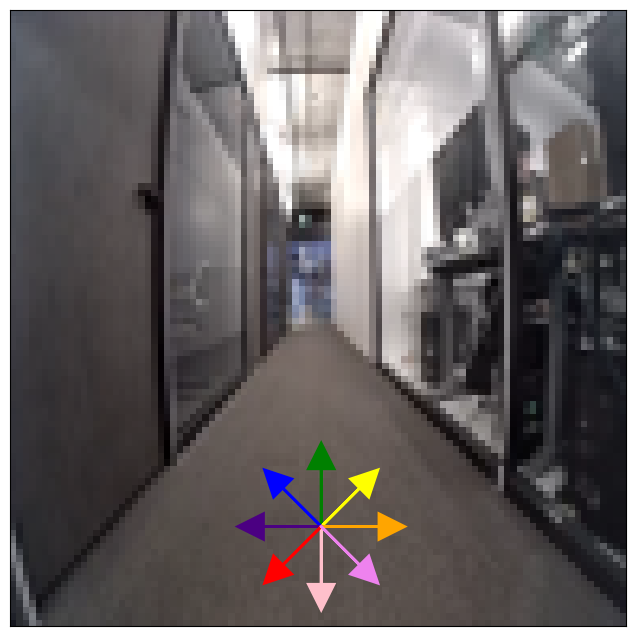

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the existing image
image_path = "./corridor_pic.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib

# Define the starting position (1/3 from the bottom of the image)
img_h, img_w, _ = image.shape
start_x, start_y = img_w // 2, int(img_h * 5 / 6)  # 1/3 from the bottom

# Define movement directions
angles = {
    "forward": (np.radians(0), "green"),           
    "forward_right": (np.radians(-45), "yellow"),    
    "forward_left": (np.radians(45), "blue"),    
    "right": (np.radians(-90), "orange"),             
    "left": (np.radians(90), "indigo"),              
    "back": (np.radians(180), "pink"),          
    "back_right": (np.radians(135), "red"),     
    "back_left": (np.radians(225), "violet"),        
}

# Define a relative arrow length (percentage of image width)
arrow_length = int(img_w * 0.1)  # 10% of the image width
arrow_head_width = int(img_w * 0.05)
arrow_head_length = int(img_w * 0.05)
# Create figure
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(image)

# Overlay directional arrows
for direction in angles.keys():
    angle, color = angles[direction]
    angle += np.radians(90)

    dx = int(arrow_length * np.cos(angle))
    dy = int(-arrow_length * np.sin(angle))  # Negative Y because image coordinates are inverted

    ax.arrow(
        start_x, start_y, dx, dy,
        head_width=arrow_head_width, head_length=arrow_head_length, fc=color, ec=color, linewidth=2
    )

# Hide axes
ax.set_xticks([])
ax.set_yticks([])

plt.show()


In [57]:
# combine images when one is transparent! 

from PIL import Image

# Open both images
image2_path = "directions overlay.png"  # The image with transparency

# Load the images with alpha channel (RGBA format)
image1 = img
image2 = Image.open(image2_path).convert("RGBA")

# Optional: Resize images to the same size (if needed)
image2 = image2.resize(image1.size)

# Overlay image2 on top of image1 (the transparent one will blend)
result = Image.alpha_composite(image1, image2)

# Optionally, show the result
result.show()


Opening in existing browser session.


In [ ]:
# combine images when one is transparent! 

from PIL import Image

# Open both images
image1_path = "image1.png"  # The base image
image2_path = "image2.png"  # The image with transparency

# Load the images with alpha channel (RGBA format)
image1 = Image.open(image1_path).convert("RGBA")
image2 = Image.open(image2_path).convert("RGBA")

# Optional: Resize images to the same size (if needed)
image2 = image2.resize(image1.size)

# Overlay image2 on top of image1 (the transparent one will blend)
result = Image.alpha_composite(image1, image2)

# Save the result
result.save("overlayed_image.png", "PNG")

# Optionally, show the result
result.show()


Opening in existing browser session.


# Trying Again February

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()
import matplotlib 

import os
from openai import OpenAI

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

## Mapping

In [2]:
# Goal: based on observation history and map with longer location history, repeatedly tell me what to do to get closer to the goal. 

# Need orientation drawn on map I think.... otherwise will be wonky 
def convert_angle_compass_to_cartesian(compass):
    return(((360 - compass) % 360) + 90) % 360

# OpenAI Setup
key = os.environ.get("OPENAI_API_KEY")
client = OpenAI(api_key = key)

# Mapping Setup
tiler = cimgt.OSM()
crs = tiler.crs

In [3]:
cur_pos = np.array([37.873550 , -122.267617])
campanile_pos = np.array([37.87210, -122.25780])

points = np.vstack([cur_pos, campanile_pos])
min_lat, min_long = np.min(points, axis = 0)
max_lat, max_long = np.max(points, axis = 0)

border = 0.001
bounds = [[min_lat - border, min_long - border],
          [max_lat + border, max_long + border]]

marker_size = 10

[1]
[1]
[1]
[1]


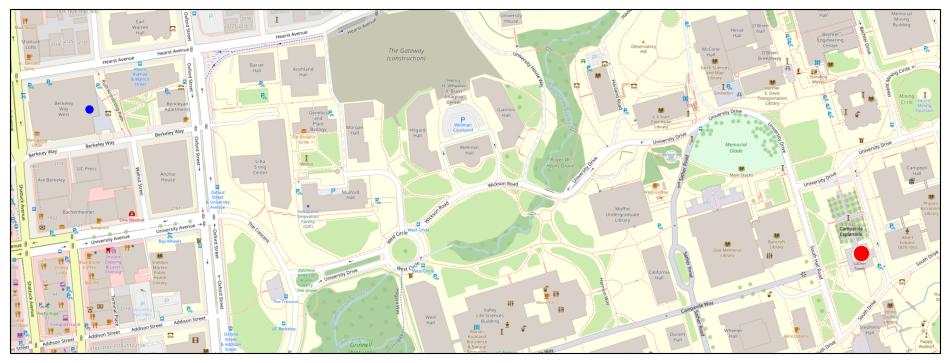

In [11]:
# Generate map
goal_point = campanile_pos

fig, ax = plt.subplots(
        figsize=(12, 10),
        subplot_kw={"projection": crs}
    )
print(plt.get_fignums())

ax.set_extent([bounds[0][1], bounds[1][1] , 
            bounds[0][0], bounds[1][0]], 
            crs=ccrs.PlateCarree())

print(plt.get_fignums())
# Add OpenStreetMap tiles
ax.add_image(tiler, 18)  # Zoom level (lower values = less zoomed-in)

print(plt.get_fignums())
ax.plot(
        goal_point[1], goal_point[0],
        marker="o", color="red", markersize=marker_size,
        transform=ccrs.PlateCarree()
    )


plt.savefig("./duh.png", dpi=300, bbox_inches='tight')
print(plt.get_fignums())

ax.plot(
        cur_pos[1], cur_pos[0],
        marker="o", color="green", markersize=marker_size,
        transform=ccrs.PlateCarree()
    )

plt.savefig("./nope.png", dpi=300, bbox_inches="tight")

# remove last point 

for artist in reversed(ax.get_children()):
    if isinstance(artist, matplotlib.lines.Line2D) and artist.get_marker() == "o":
        artist.set_color("blue")  # Change latest to be a history point instead
        artist.set_markersize(5)
        break

plt.savefig("./later.png", dpi=300, bbox_inches="tight")

In [8]:
plt.get_fignums()

[]

In [15]:
ax.plot(
        cur_pos[1], cur_pos[0],
        marker="o", color="red", markersize=marker_size,
        transform=ccrs.PlateCarree()
    )

In [7]:
plt.show()

In [8]:
plt.get_fignums()

[]

In [6]:
ax.show()

AttributeError: 'GeoAxes' object has no attribute 'show'

In [18]:
plt.show()

In [8]:
def generate_map(bounds, goal_point, marker_size = 10):
    """
    Bounds: [[min latitude, min longitude], [max latitude, max longitude]]
    Goal point: [latitude, longitude]
    """
    fig, ax = plt.subplots(
        figsize=(12, 10),
        subplot_kw={"projection": crs}
    )

    ax.set_extent([bounds[0][1], bounds[1][1] , 
                bounds[0][0], bounds[1][0]], 
                crs=ccrs.PlateCarree())

    # Add OpenStreetMap tiles
    ax.add_image(tiler, 18)  # Zoom level (lower values = less zoomed-in)

    ax.plot(
            goal_point[1], goal_point[0],
            marker="o", color="red", markersize=marker_size,
            transform=ccrs.PlateCarree()
        )

    # plt.savefig(save_loc, dpi=300, bbox_inches='tight')
    # if show:

    # plt.show()
    return fig, ax


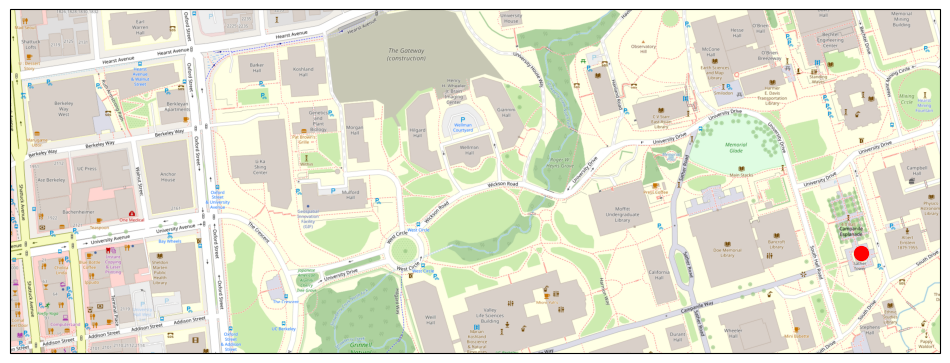

In [9]:
fig, ax = generate_map(bounds, campanile_pos)

In [6]:
plt.get_fignums()

[]

In [7]:
fig.show()

/tmp/ipykernel_2426580/89474557.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [21]:
# Remove Last Point 
def remove_last_point(fig, ax):

    for artist in reversed(ax.get_children()):
        if isinstance(artist, matplotlib.lines.Line2D) and artist.get_marker() == "o":
            artist.remove()  # Remove the last plotted marker
            break
    return fig, ax

In [24]:
fig, ax = remove_last_point(fig, ax)

In [25]:
plt.show()

In [26]:
fig.canvas.draw()

In [20]:
ax.get_children()

 Text(0.5, 1.0, ''),
 Text(0.0, 1.0, ''),
 Text(1.0, 1.0, ''),

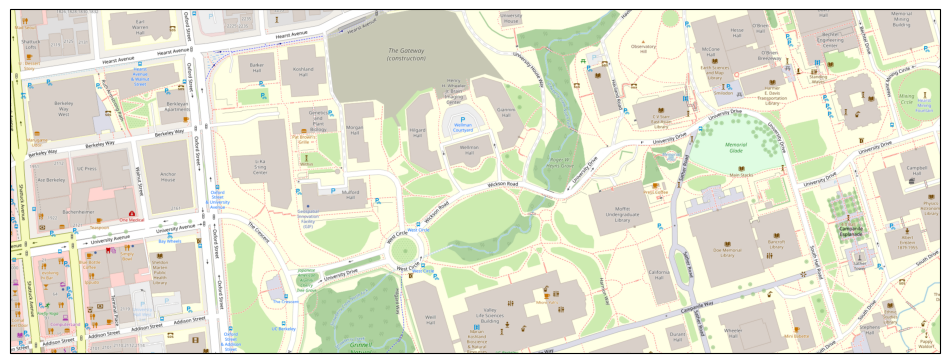

In [16]:
fig, ax = plt.subplots(
    figsize=(12, 10),
    subplot_kw={"projection": crs}
)

ax.set_extent([min_long - border, max_long + border , 
               min_lat -border , max_lat + border], 
               crs=ccrs.PlateCarree())

# Add OpenStreetMap tiles
ax.add_image(tiler, 18)  # Zoom level (lower values = less zoomed-in)

# # Plot points
# for lat, lon in other_options:
#     ax.plot(
#         lon, lat,
#         marker="o", color="purple", markersize=marker_size,
#         transform=ccrs.PlateCarree()
#     )

# ax.plot(
#         pos_history[-1][1], pos_history[-1][0],
#         marker="o", color="green", markersize=marker_size,
#         transform=ccrs.PlateCarree()
#     )

# ax.plot(
#         goal_pos[1], goal_pos[0],
#         marker="o", color="red", markersize=marker_size,
#         transform=ccrs.PlateCarree()
#     )

# plt.savefig(save_loc, dpi=300, bbox_inches='tight')
# if show:

plt.show()

In [7]:
# Generate Map


def generate_map(pos_history, goal_pos, border, text_offset, marker_size, save_loc, show = False):
    positions = np.vstack([pos_history, goal_pos])
    min_lat, min_long = np.min(positions, axis = 0)
    max_lat, max_long = np.max(positions, axis = 0)
    
    fig, ax = plt.subplots(
        figsize=(12, 10),
        subplot_kw={"projection": crs}
    )

    ax.set_extent([min_long - border, max_long + border , 
                 min_lat -border , max_lat + border], 
                crs=ccrs.PlateCarree())

    # Add OpenStreetMap tiles
    ax.add_image(tiler, 18)  # Zoom level (lower values = less zoomed-in)

    # Plot points
    for lat, lon in other_options:
        ax.plot(
            lon, lat,
            marker="o", color="purple", markersize=marker_size,
            transform=ccrs.PlateCarree()
        )

    ax.plot(
            pos_history[-1][1], pos_history[-1][0],
            marker="o", color="green", markersize=marker_size,
            transform=ccrs.PlateCarree()
        )

    ax.plot(
            goal_pos[1], goal_pos[0],
            marker="o", color="red", markersize=marker_size,
            transform=ccrs.PlateCarree()
        )

    plt.savefig(save_loc, dpi=300, bbox_inches='tight')
    if show:
        plt.show()

    plt.clf()

# Path Planning

In [10]:
import os
import base64
import matplotlib.pyplot as plt
from matplotlib import cm
import openai 
from openai import OpenAI
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import numpy as np
from agentlace.action import ActionClient
import utils
import time
import re

import logging

# Suppress debug logs for PIL and matplotlib
logging.getLogger("PIL").setLevel(logging.INFO)
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger('httpcore').setLevel(logging.WARNING)
logging.getLogger('httpx').setLevel(logging.WARNING)

# OpenAI Setup
key = os.environ.get("OPENAI_API_KEY")
client = OpenAI(api_key = key)

# Mapping Setup
tiler = cimgt.OSM()
crs = tiler.crs


goal_dist = 12 
planning_prompt = f"""
I am a wheeled robot, and you want to help me navigate to my desired goal position. 

I am able to take actions of the format (x, theta) where x represents my linear velocity, and theta represents my angular velocity. Both of these can be in the range (-1, 1), where -1 is going backwards for x, or to the right for theta. Sending one action usually makes me move by up to one foot in a given direction.
Sometimes, I stop being able to make progress on my path. 

I am giving you a birds eye view map of my environment. On the map, 
My current position is specified with a green dot, labelled C. 
My desired goal position is specified with a red dot, labelled G.
For context, C and G are {goal_dist} meters apart. 

It is easier to navigate to a closer goal first, on the way to G. The other goals I can go towards on my way to G are specified with purple dots, numbered 0-7. 
Try to stay close to dotted paths and sidewalks when possible, as well as trying to go as straight as possible when obstacles such as buildings are not in the way. 

Please respond to this message in the following format:
"Suggested intermediate goal: [Pick an index of the purple dot which seems most appropriate];
Reason for intermediate goal: [Explanation of why the chosen index is a good approach]"
"""

def test_points_eight(pos, offset):
    offsets = [[-1 * offset, -1 * offset], [-1 * offset, 0], [-1 * offset, offset],
            [0, -1 * offset],  [0, offset],
            [offset, -1 * offset], [offset, 0], [offset, offset]]
    
    return np.array([pos + np.array([i, j]) for i, j in offsets])

In [ ]:
cur_pos = np.array([37.873550 , -122.267617])
campanile_pos = np.array([37.87210, -122.25780])
goal_pos = campanile_pos
positions = np.vstack([cur_pos, goal_pos])

min_lat, min_long = np.min(positions, axis = 0)
max_lat, max_long = np.max(positions, axis = 0)
test_offset = max(max_lat - min_lat, max_long - min_long) / 8
other_options  = test_points_eight(goal_pos, test_offset)

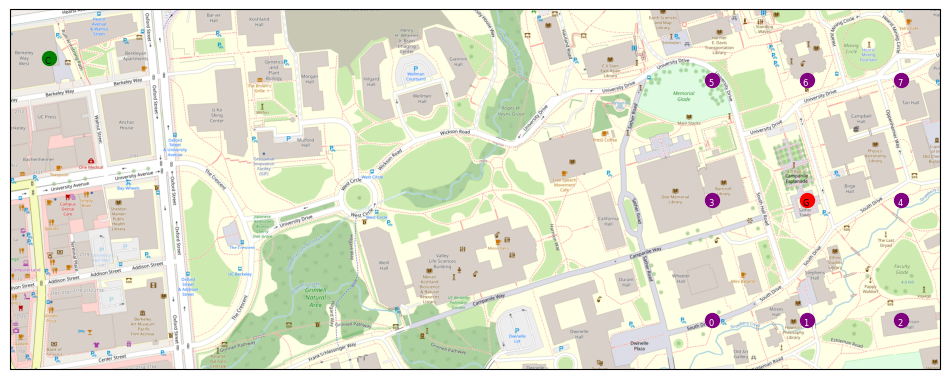

<Figure size 640x480 with 0 Axes>

In [16]:
border = 0.0005
marker_size = 10
text_offset = 0.00005


positions = np.vstack([cur_pos, goal_pos, other_options])
min_lat, min_long = np.min(positions, axis = 0)
max_lat, max_long = np.max(positions, axis = 0)

fig, ax = plt.subplots(
    figsize=(12, 10),
    subplot_kw={"projection": crs}
)

ax.set_extent([min_long - border, max_long + border , 
            min_lat -border , max_lat + border], 
            crs=ccrs.PlateCarree())

# Add OpenStreetMap tiles
ax.add_image(tiler, 18)  # Zoom level (lower values = less zoomed-in)

# Plot points
for lat, lon in other_options:
    ax.plot(
        lon, lat,
        marker="o", color="purple", markersize=marker_size,
        transform=ccrs.PlateCarree()
    )

ax.plot(
        cur_pos[1], cur_pos[0],
        marker="o", color="green", markersize=marker_size,
        transform=ccrs.PlateCarree()
    )

ax.plot(
        goal_pos[1], goal_pos[0],
        marker="o", color="red", markersize=marker_size,
        transform=ccrs.PlateCarree()
    )

# Add point labels
ax.text(cur_pos[1] - text_offset, cur_pos[0] - text_offset, 'C', transform=ccrs.PlateCarree(), fontsize=6, color="Black")
ax.text(goal_pos[1] - text_offset, goal_pos[0] - text_offset, 'G', transform=ccrs.PlateCarree(), fontsize=6, color="Black")
for idx, (lat, lon) in enumerate(other_options):
    ax.text(lon - text_offset , lat - text_offset, f'{idx}', transform=ccrs.PlateCarree(), fontsize=6, color="White")

# plt.savefig(save_loc, dpi=300, bbox_inches='tight')
plt.show()
plt.clf()

In [ ]:
positions = np.vstack([cur_pos, goal_pos, other_options])
min_lat, min_long = np.min(positions, axis = 0)
max_lat, max_long = np.max(positions, axis = 0)

fig, ax = plt.subplots(
    figsize=(12, 10),
    subplot_kw={"projection": crs}
)

ax.set_extent([min_long - border, max_long + border , 
            min_lat -border , max_lat + border], 
            crs=ccrs.PlateCarree())

# Add OpenStreetMap tiles
ax.add_image(tiler, 18)  # Zoom level (lower values = less zoomed-in)

# Plot points
for lat, lon in other_options:
    ax.plot(
        lon, lat,
        marker="o", color="purple", markersize=marker_size,
        transform=ccrs.PlateCarree()
    )

ax.plot(
        cur_pos[1], cur_pos[0],
        marker="o", color="green", markersize=marker_size,
        transform=ccrs.PlateCarree()
    )

ax.plot(
        goal_pos[1], goal_pos[0],
        marker="o", color="red", markersize=marker_size,
        transform=ccrs.PlateCarree()
    )

# Add point labels
ax.text(cur_pos[1] - text_offset, cur_pos[0] - text_offset, 'C', transform=ccrs.PlateCarree(), fontsize=6, color="Black")
ax.text(goal_pos[1] - text_offset, goal_pos[0] - text_offset, 'G', transform=ccrs.PlateCarree(), fontsize=6, color="Black")
for idx, (lat, lon) in enumerate(other_options):
    ax.text(lon - text_offset , lat - text_offset, f'{idx}', transform=ccrs.PlateCarree(), fontsize=6, color="White")

plt.savefig(save_loc, dpi=300, bbox_inches='tight')
if show:
    plt.show()

plt.clf()



In [8]:
cur_pos = np.array([37.873550 , -122.267617])
campanile_pos = np.array([37.87210, -122.25780])
goal_pos = campanile_pos

In [ ]:
cur_pos = np.array([37.873550 , -122.267617])
campanile_pos = np.array([37.87210, -122.25780])
goal_pos = campanile_pos  
# goal_pos = np.array([37.873289 , -122.267378])
goals_list = generate_intermediate_goals(cur_pos, goal_pos, threshold = 0.005)

In [ ]:
cur_pos = np.array([37.873550 , -122.267617])
campanile_pos = np.array([37.87210, -122.25780])
goal_pos = campanile_pos  
# goal_pos = np.array([37.873289 , -122.267378])
goals_list = generate_intermediate_goals(cur_pos, goal_pos, threshold = 0.005)

# Whole System

In [5]:
import os
import base64
import matplotlib.pyplot as plt
from matplotlib import cm
import openai 
from openai import OpenAI
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import numpy as np
from agentlace.action import ActionClient
import utils
import time
import re

import logging

# Suppress debug logs for PIL and matplotlib
logging.getLogger("PIL").setLevel(logging.INFO)
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger('httpcore').setLevel(logging.WARNING)
logging.getLogger('httpx').setLevel(logging.WARNING)

# OpenAI Setup
key = os.environ.get("OPENAI_API_KEY")
client = OpenAI(api_key = key)

# FrodoBot Setup
# action_client = ActionClient(
#             server_ip="localhost",
#             config=utils.make_action_config("frodobot")
#         )

# Mapping Setup
tiler = cimgt.OSM()
crs = tiler.crs

def test_points_eight(pos, offset):
    offsets = [[-1 * offset, -1 * offset], [-1 * offset, 0], [-1 * offset, offset],
            [0, -1 * offset],  [0, offset],
            [offset, -1 * offset], [offset, 0], [offset, offset]]
    
    return np.array([pos + np.array([i, j]) for i, j in offsets])

def generate_map(cur_pos, goal_pos, other_options, border, text_offset, marker_size, save_loc, show = False):
    positions = np.vstack([cur_pos, goal_pos, other_options])
    min_lat, min_long = np.min(positions, axis = 0)
    max_lat, max_long = np.max(positions, axis = 0)
    
    fig, ax = plt.subplots(
        figsize=(12, 10),
        subplot_kw={"projection": crs}
    )

    ax.set_extent([min_long - border, max_long + border , 
                min_lat -border , max_lat + border], 
                crs=ccrs.PlateCarree())

    # Add OpenStreetMap tiles
    ax.add_image(tiler, 18)  # Zoom level (lower values = less zoomed-in)

    # Plot points
    for lat, lon in other_options:
        ax.plot(
            lon, lat,
            marker="o", color="purple", markersize=marker_size,
            transform=ccrs.PlateCarree()
        )

    ax.plot(
            cur_pos[1], cur_pos[0],
            marker="o", color="green", markersize=marker_size,
            transform=ccrs.PlateCarree()
        )

    ax.plot(
            goal_pos[1], goal_pos[0],
            marker="o", color="red", markersize=marker_size,
            transform=ccrs.PlateCarree()
        )

    # Add point labels
    ax.text(cur_pos[1] - text_offset, cur_pos[0] - text_offset, 'C', transform=ccrs.PlateCarree(), fontsize=6, color="Black")
    ax.text(goal_pos[1] - text_offset, goal_pos[0] - text_offset, 'G', transform=ccrs.PlateCarree(), fontsize=6, color="Black")
    for idx, (lat, lon) in enumerate(other_options):
        ax.text(lon - text_offset , lat - text_offset, f'{idx}', transform=ccrs.PlateCarree(), fontsize=6, color="White")

    plt.savefig(save_loc, dpi=300, bbox_inches='tight')
    if show:
        plt.show()

    plt.clf()

def generate_rainbow_map(points, border, text_offset, marker_size, show=False):
    # Convert list of points to a numpy array for easier manipulation
    points_array = np.array(points)
    min_lat, min_long = np.min(points_array, axis=0)
    max_lat, max_long = np.max(points_array, axis=0)

    # Set up the map projection and figure
    fig, ax = plt.subplots(
        figsize=(12, 10),
        subplot_kw={"projection": ccrs.PlateCarree()}
    )

    ax.set_extent([min_long - border, max_long + border, 
                   min_lat - border, max_lat + border], 
                   crs=ccrs.PlateCarree())

    # Add OpenStreetMap tiles
    tiler = cimgt.OSM()
    ax.add_image(tiler, 18)  # Zoom level

    # Color map 
    color_map = cm.viridis  
    
    # Normalize the points index to map them to the color map
    num_points = len(points)
    norm = plt.Normalize(vmin=0, vmax=num_points - 1)

    # Plot each point with corresponding color
    for idx, (lat, lon) in enumerate(points):
        color = color_map(norm(idx))  # Get the color based on the index
        ax.plot(lon, lat, marker="o", color=color, markersize=marker_size, transform=ccrs.PlateCarree())
        
    plt.show()

correction_to_action = { # linear, angular, frequency
    "back0": [(-1., 0., 3)],
    "back45left": [(-1., 0., 1), (-1., -1., 1)],
    "back45right": [(-1., 0., 1), (-1., 1., 1)],
    "back90left": [(-1., 0., 1), (-0.5, -1., 3)],
    "back90right": [(-1., 0., 1), (-0.5, 1., 3)],
    "back180": [(-1., 0., 1), [0.5, 1., 6]],
    "front45left": [(1., 0., 1), (1., 1., 1)],
    "front45right": [(1., 0., 1), (1., -1., 1)],
    "front90left": [(1., 0., 1), (0.5, 1., 3)],
    "front90right": [(1., 0., 1), (0.5, -1., 3)],
    "front180": [(1., 0., 1), (0.5, -1., 6)],
    "back180": [(-1., 0., 1), (0.5, -1., 6)],
}

corrections_idx = [
    "back0",
    "back45left",
    "back45right",
    "back90left",
    "back90right",
    "back180",
    "front45left",
    "front45right",
    "front90left",
    "front90right", 
    "front180",
    "back180",
]

def make_correction(idx):
    correction = corrections_idx[idx]
    actions = correction_to_action[correction]

    for lin, ang, freq in actions:
        for _ in range(freq):
            action_client.act("action_vw", np.array([lin, ang]))
            time.sleep(0.2)

def encode_image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        img_b64_bytes = base64.b64encode(image_file.read())
        img_b64_str = img_b64_bytes.decode("utf-8")
    return img_b64_str

planning_prompt = f"""
I am a wheeled robot, and you want to help me navigate to my desired goal position. 

I am able to take actions of the format (x, theta) where x represents my linear velocity, and theta represents my angular velocity. Both of these can be in the range (-1, 1), where -1 is going backwards for x, or to the right for theta. Sending one action usually makes me move by up to one foot in a given direction.
Sometimes, I stop being able to make progress on my path. 

I am giving you a birds eye view map of my environment. 
My current position is specified with a green dot, labelled C. 
My desired goal position is specified with a red dot, labelled G.
The other goals I can go towards on my way to G are specified with purple dots, numbered 0-7. 

I want to make my life easier and get to one of the alterative goals before continuing on to the final goal. 
Try to stay close to dotted paths and roads when possible, as well as generally trying to go as straight as possible when obstacles such as buildings are not in the way. 

Please respond to this message in the following format:
"Suggested intermediate goal: [Pick an index of the purple dot which seems most appropriate];
Reason for intermediate goal: [Explanation of why the chosen index is a good approach]"
"""

help_prompt = f"""
I am a wheeled robot, and you want to help me navigate to my desired goal position. 

I am able to take actions of the format (x, theta) where x represents my linear velocity, and theta represents my angular velocity. Both of these can be in the range (-1, 1), where -1 is going backwards for x, or to the right for theta. Sending one action usually makes me move by up to one foot in a given direction.
Sometimes, I stop being able to make progress on my path. 

I am giving you a birds eye view map of my environment, as well as my point of view both in front of me and behind me.

My current position is specified with a green dot, labelled C. 
My desired goal position is specified with a red dot, labelled G.
I have stopped being able to make progress towards my desired goal. 

My options for interventions to get back on track are:
0. Back straight up
1. Back up and turn 45 degrees to the right
2. Back up and turn 45 degrees to the left
3. Back up and turn 90 degrees to the right
4. Back up and turn 90 degrees to the left
5. Back up and turn 180 degrees
6. Move forward and turn 45 degrees to the right
7. Move forward and turn 45 degrees to the left
8. Move forward and turn 90 degrees to the right
9. Move forward and turn 90 degrees to the left
10. Move forward and turn 180 degrees
11. Move backward and turn 180 degrees

In the absolute worst case, I can call for human intervention, which you can reference with index 12, but this should be reserved for extreme cases.

Please respond to this message in the following format:
"Suggested intervention: [Pick the index of the most appropriate intervention];
Reason for intervention: [Explanation of why the chosen index is a good approach]"
"""

def generate_intermediate_goals(cur_pos, goal_pos, threshold):
        
    goals = [goal_pos] 

    i = 0
    while np.linalg.norm(goals[-1]) > threshold and i < 6:
        goal_pos = goals[-1]
        positions = np.vstack([cur_pos, goal_pos])
        min_lat, min_long = np.min(positions, axis = 0)
        max_lat, max_long = np.max(positions, axis = 0)
        test_offset = max(max_lat - min_lat, max_long - min_long) / 5
        other_options  = test_points_eight(goal_pos, test_offset)

        border = 0.0005
        marker_size = 10
        text_offset = 0.00005
        save_loc = f"step_{i}.png"

        generate_map(cur_pos, goal_pos, other_options, border, text_offset, marker_size, save_loc, show = False)

        img_type_obs = "image/png"
        img_b64_str_map = encode_image_to_base64(save_loc)

        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": planning_prompt},
                        {
                            "type": "image_url",
                            "image_url": {"url": f"data:{img_type_obs};base64,{img_b64_str_map}"},
                        },
                    ],
                }
            ],
            max_tokens = 1000,
        )

        # print(response.choices[0].message.content)
        arr_3_resp = response.choices[0].message.content.split("\n")

        choice = re.search(r'.*Suggested intermediate goal:.* (\d+);?\s*', arr_3_resp[0])

        if choice:
            last_number = choice.group(1)
        else:
            print("No number found")
            
        chosen_idx = int(last_number)
        goals.append(other_options[chosen_idx])

        i += 1

    return goals

def choose_correction(cur_pos, goal_pos):
    positions = np.vstack([cur_pos, goal_pos])
    min_lat, min_long = np.min(positions, axis = 0)
    max_lat, max_long = np.max(positions, axis = 0)

    border = 0.0005
    marker_size = 10
    text_offset = 0.00005
    save_loc = f"trash.png"

    generate_map(cur_pos, goal_pos, np.array([cur_pos, cur_pos]), border, text_offset, marker_size, save_loc, show = False)

    img_type_obs = "image/png"
    img_b64_str_map = encode_image_to_base64(save_loc)

    # # Current Observation
    obs = action_client.obs()
    img_type_obs = "image/jpeg"
    img_b64_str_obs_front = obs["front_frame"]
    img_b64_str_obs_rear = obs["rear_frame"]

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": help_prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:{img_type_obs};base64,{img_b64_str_map}"},
                    },
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:{img_type_obs};base64,{img_b64_str_obs_front}"},
                    },
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:{img_type_obs};base64,{img_b64_str_obs_rear}"},
                    },
                ],
            }
        ],
        max_tokens = 1000,
    )

    print(response.choices[0].message.content)
    arr_3_resp = response.choices[0].message.content.split("\n")

    choice = re.search(r'.*Suggested intervention:.* (\d+);?\s*', arr_3_resp[0])

    if choice:
        last_number = choice.group(1)
    else:
        print("No number found")
        
    chosen_idx = int(last_number)
    return chosen_idx

In [11]:
def generate_intermediate_goals(cur_pos, goal_pos, threshold):
        
    goals = [goal_pos] 

    i = 0
    while np.linalg.norm(goals[-1]) > threshold and i < 6:
        goal_pos = goals[-1]
        positions = np.vstack([cur_pos, goal_pos])
        min_lat, min_long = np.min(positions, axis = 0)
        max_lat, max_long = np.max(positions, axis = 0)
        test_offset = max(max_lat - min_lat, max_long - min_long) / 5
        other_options  = test_points_eight(goal_pos, test_offset)

        border = 0.0005
        marker_size = 10
        text_offset = 0.00005
        save_loc = f"step_{i}.png"

        generate_map(cur_pos, goal_pos, other_options, border, text_offset, marker_size, save_loc, show = False)

        img_type_obs = "image/png"
        img_b64_str_map = encode_image_to_base64(save_loc)

        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": planning_prompt},
                        {
                            "type": "image_url",
                            "image_url": {"url": f"data:{img_type_obs};base64,{img_b64_str_map}"},
                        },
                    ],
                }
            ],
            max_tokens = 1000,
        )

        # print(response.choices[0].message.content)
        arr_3_resp = response.choices[0].message.content.split("\n")

        choice = re.search(r'.*Suggested intermediate goal:.* (\d+);?\s*', arr_3_resp[0])

        if choice:
            last_number = choice.group(1)
        else:
            print("No number found")
            
        chosen_idx = int(last_number)
        goals.append(other_options[chosen_idx])

        i += 1

    return goals

In [ ]:
cur_pos = np.array([37.873550 , -122.267617])
campanile_pos = np.array([37.87210, -122.25780])
goal_pos = campanile_pos  
# goal_pos = np.array([37.873289 , -122.267378])
goals_list = generate_intermediate_goals(cur_pos, goal_pos, threshold = 0.005)

In [ ]:
# GENERATED PATH
goals_with_start = goals_list + [cur_pos]
border = 0.0005
marker_size = 10
text_offset = 0.00005

generate_rainbow_map(goals_with_start, border, text_offset, marker_size, True)

In [5]:
def choose_correction(cur_pos, goal_pos):
    positions = np.vstack([cur_pos, goal_pos])
    min_lat, min_long = np.min(positions, axis = 0)
    max_lat, max_long = np.max(positions, axis = 0)

    border = 0.0005
    marker_size = 10
    text_offset = 0.00005
    save_loc = f"trash.png"

    generate_map(cur_pos, goal_pos, np.array([cur_pos, cur_pos]), border, text_offset, marker_size, save_loc, show = False)

    img_type_obs = "image/png"
    img_b64_str_map = encode_image_to_base64(save_loc)

    # # Current Observation
    obs = action_client.obs()
    img_type_obs = "image/jpeg"
    img_b64_str_obs_front = obs["front_frame"]
    img_b64_str_obs_rear = obs["rear_frame"]

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": help_prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:{img_type_obs};base64,{img_b64_str_map}"},
                    },
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:{img_type_obs};base64,{img_b64_str_obs_front}"},
                    },
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:{img_type_obs};base64,{img_b64_str_obs_rear}"},
                    },
                ],
            }
        ],
        max_tokens = 1000,
    )

    print(response.choices[0].message.content)
    arr_3_resp = response.choices[0].message.content.split("\n")

    choice = re.search(r'.*Suggested intervention:.* (\d+);?\s*', arr_3_resp[0])

    if choice:
        last_number = choice.group(1)
    else:
        print("No number found")
        
    chosen_idx = int(last_number)
    return chosen_idx
        



In [ ]:
cur_pos = np.array([37.873550 , -122.267617])
goal_pos = goals_list[-1]

c = choose_correction(cur_pos, goal_pos)
make_correction(c)

In [23]:
import time

In [35]:
make_correction(9)

In [ ]:
cur_pos = np.array([37.873550 , -122.267617])
campanile_pos = np.array([37.87210, -122.25780])
goal_pos = campanile_pos
# goal_pos = np.array([37.873289 , -122.267378])

goal_pos = goals_list[-1]
positions = np.vstack([cur_pos, goal_pos])
min_lat, min_long = np.min(positions, axis = 0)
max_lat, max_long = np.max(positions, axis = 0)

border = 0.0005
marker_size = 10
text_offset = 0.00005
save_loc = f"trash.png"

generate_map(cur_pos, goal_pos, np.array([cur_pos, cur_pos]), border, text_offset, marker_size, save_loc, show = False)

img_type_obs = "image/png"
img_b64_str_map = encode_image_to_base64(save_loc)

# # Current Observation
obs = action_client.obs()
img_type_obs = "image/jpeg"
img_b64_str_obs_front = obs["front_frame"]
img_b64_str_obs_rear = obs["rear_frame"]

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": help_prompt},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:{img_type_obs};base64,{img_b64_str_map}"},
                },
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:{img_type_obs};base64,{img_b64_str_obs_front}"},
                },
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:{img_type_obs};base64,{img_b64_str_obs_rear}"},
                },
            ],
        }
    ],
    max_tokens = 1000,
)

print(response.choices[0].message.content)
arr_3_resp = response.choices[0].message.content.split("\n")

choice = re.search(r'.*Suggested intervention goal:.* (\d+);?\s*', arr_3_resp[0])

if choice:
    last_number = choice.group(1)
else:
    print("No number found")
    
chosen_idx = int(last_number)
# goals.append(other_options[chosen_idx])


In [ ]:
90 degrees = 
def correction_to_action(direction, angle):
    if angle = None:


options

linear = [-1, 1]
angular = []

# Putting it Together

In [ ]:
import os
import base64
import matplotlib.pyplot as plt
import openai 
from openai import OpenAI
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import numpy as np
from agentlace.action import ActionClient
import utils

import logging

# Suppress debug logs for PIL and matplotlib
logging.getLogger("PIL").setLevel(logging.INFO)
logging.getLogger("matplotlib").setLevel(logging.WARNING)

# OpenAI Setup
key = os.environ.get("OPENAI_API_KEY")
client = OpenAI(api_key = key)

prompt = f"""I am a cute little robot, and you want to help me navigate to my desired goal position.
I am able to take actions of the format (x, theta) where x represents my linear velocity, and theta represents my angular velocity. Both of these can be in the range (-1, 1), where -1 is going backwards for x, or to the right for theta. Sending one action usually makes me move by up to one foot in a given direction.
Sometimes, I stop being able to make progress on my path. 
I also hate bumping into things and people. That might not be safe! I don't want to break or be rude.

I am giving you a picture showing what I can see from my front camera. 

Right now, I'm not making enough progress towards my goal, so I want to find a new goal on my way over.
I am also giving you a map of what is going on. 
My current position is specified with a green dot, labelled C. 
My desired goal position is specified with a red dot, labelled G.
The alterative goals I can go towards on my way to G are specified with purple dots, numbered 0-7. 

Please respond to this message in the following format:
"Reason for not making progress: [Explain why it seems like I'm not making progress towards the goal based on the map and observation.];
Suggested next goal: [Pick an index of the purple dot which seems most appropriate];
Reason for next goal: [Explanation of why the chosen index is a good approach]"
"""

# FrodoBot Setup
action_client = ActionClient(
            server_ip="localhost",
            config=utils.make_action_config("frodobot")
        )

# Mapping Setup
tiler = cimgt.OSM()
crs = tiler.crs
current_img = "test_img.png"

In [2]:
# HELPER FUNCTIONS
def test_points_eight(pos, offset):
    offsets = [[-1 * offset, -1 * offset], [-1 * offset, 0], [-1 * offset, offset],
            [0, -1 * offset],  [0, offset],
            [offset, -1 * offset], [offset, 0], [offset, offset]]
    
    return np.array([pos + np.array([i, j]) for i, j in offsets])

def generate_map(cur_pos, goal_pos, other_options, border, text_offset, save_loc):
    
    coords = np.vstack([other_options, cur_pos, goal_pos])

    # create the map 
    fig, ax = plt.subplots(
        figsize=(12, 10),
        subplot_kw={"projection": crs}
    )

    # find & set plotting bounds
    min_lat, min_long = np.min(coords, axis = 0)
    max_lat, max_long = np.max(coords, axis = 0)
    ax.set_extent([min_long - border, max_long + border, 
                min_lat - border/ 2, max_lat + border / 2], 
                crs=ccrs.PlateCarree())

    # Add OpenStreetMap tiles
    ax.add_image(tiler, 18)  # Zoom level (lower values = less zoomed-in)

    # Plot points
    ax.plot(
            cur_pos[1], cur_pos[0],
            marker="o", color="green", markersize=8,
            transform=ccrs.PlateCarree()
        )

    ax.plot(
            goal_pos[1], goal_pos[0],
            marker="o", color="red", markersize=8,
            transform=ccrs.PlateCarree()
        )

    for lat, lon in other_options:
        ax.plot(
            lon, lat,
            marker="o", color="purple", markersize=8,
            transform=ccrs.PlateCarree()
        )

    # Add point labels
    ax.text(cur_pos[1] - text_offset, cur_pos[0] - text_offset, 'C', transform=ccrs.PlateCarree(), fontsize=6, color="Black")
    ax.text(goal_pos[1] - text_offset, goal_pos[0] - text_offset, 'G', transform=ccrs.PlateCarree(), fontsize=6, color="Black")
    for idx, (lat, lon) in enumerate(other_options):
        ax.text(lon - text_offset , lat - text_offset, f'{idx}', transform=ccrs.PlateCarree(), fontsize=6, color="White")

    # Save  map
    plt.savefig(save_loc, dpi=300, bbox_inches='tight')

def encode_image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        img_b64_bytes = base64.b64encode(image_file.read())
        img_b64_str = img_b64_bytes.decode("utf-8")
    return img_b64_str



In [3]:
goals = [np.array([37.873289 , -122.267378]) ]
cur_pos = np.array([37.873550 , -122.267617])
test_offset = 0.00008

In [ ]:
# Map 
goal_pos = goals[0]
other_options = test_points_eight(goal_pos, test_offset)
generate_map(cur_pos, goal_pos, other_options, 0.0015, 0.000011, current_img)
img_type_obs = "image/png"
img_b64_str_map = encode_image_to_base64(current_img)

# Current Observation
obs = action_client.obs()
img_type_obs = "image/jpeg"
img_b64_str_obs = obs["front_frame"]


response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:{img_type_obs};base64,{img_b64_str_obs}"},
                },
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:{img_type_obs};base64,{img_b64_str_map}"},
                },
            ],
        }
    ],
    max_tokens = 1000,
)

In [ ]:
print(response.choices[0].message.content)
arr_3_resp = response.choices[0].message.content.split("\n\n")
chosen_idx = int(arr_3_resp[1][-1])
goals.insert(0, other_options[chosen_idx])

In [ ]:
plt.imshow(utils.decode_from_base64(obs["front_frame"]))
plt.show()

In [ ]:
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages= [
    {
      "role": "system",
      "content": 
        [{
          "type": "text",
          "text": """
            You are a helpful assistant that answers programming questions 
            in the style of a southern belle from the southeast United States.
          """
        }]
      
    },
    {
      "role": "user",
      "content": 
        [{
          "type": "text",
          "text": "Are semicolons optional in JavaScript?"
        }]
      
    }
    ],
    max_tokens = 1000,
)

In [ ]:
print(response.choices[0].message.content)